In [13]:

import os
# import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

In [14]:
DATA_PATH = "Fraud.csv"  


assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found. Download dataset and place here."


df = pd.read_csv(DATA_PATH)

print("shape:", df.shape)
df.head()


shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:

df.info()
df.describe(include='all').T


missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Series([], dtype: int64)

In [16]:

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("num:", num_cols)
print("cat:", cat_cols)


num: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
cat: ['type', 'nameOrig', 'nameDest']


# Outlier

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df_num):
    X = df_num.fillna(0).astype(float)
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                    index=X.columns)
    return vif.sort_values(ascending=False)


In [18]:

if 'amount' in df.columns:
    df['amount_log1p'] = np.log1p(df['amount'].abs())


if 'tx_timestamp' in df.columns:
    df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'])
    df['hour'] = df['tx_timestamp'].dt.hour
    df['dayofweek'] = df['tx_timestamp'].dt.dayofweek


# Use stratified split

In [19]:

TARGET = 'isFraud'  
if TARGET not in df.columns:
   
    print("Target not found. Please set TARGET to the actual name.")
else:
    train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df[TARGET], random_state=42)
    print("Train:", train_df.shape, "Valid:", valid_df.shape)


Train: (5090096, 12) Valid: (1272524, 12)


In [20]:
from category_encoders import TargetEncoder

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_enc', TargetEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, [c for c in num_cols if c != TARGET]),
    ('cat', cat_transformer, [c for c in cat_cols])
], remainder='drop')


# Model

In [21]:

features = [c for c in train_df.columns if c != TARGET]

X_train = train_df[features]
y_train = train_df[TARGET]
X_valid = valid_df[features]
y_valid = valid_df[TARGET]


model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),  # removed n_jobs
    ('clf', model)
])

pipeline.fit(X_train, y_train)


,steps,"[('preproc', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluation 

ROC AUC: 0.9787
PR AUC : 0.363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.09      0.16      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.54      0.58   1272524
weighted avg       1.00      1.00      1.00   1272524



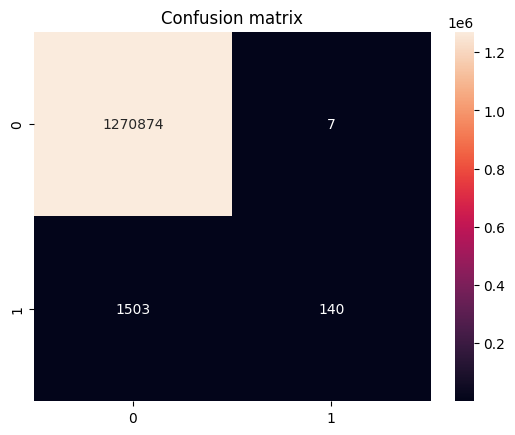

In [22]:

y_pred_proba = pipeline.predict_proba(X_valid)[:,1]
roc = roc_auc_score(y_valid, y_pred_proba)


prec, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
pr_auc = auc(recall, prec)

print("ROC AUC:", round(roc,4))
print("PR AUC :", round(pr_auc,4))

th = 0.5
y_pred = (y_pred_proba >= th).astype(int)
print(classification_report(y_valid, y_pred))
conf_mat = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d'); plt.title('Confusion matrix'); plt.show()


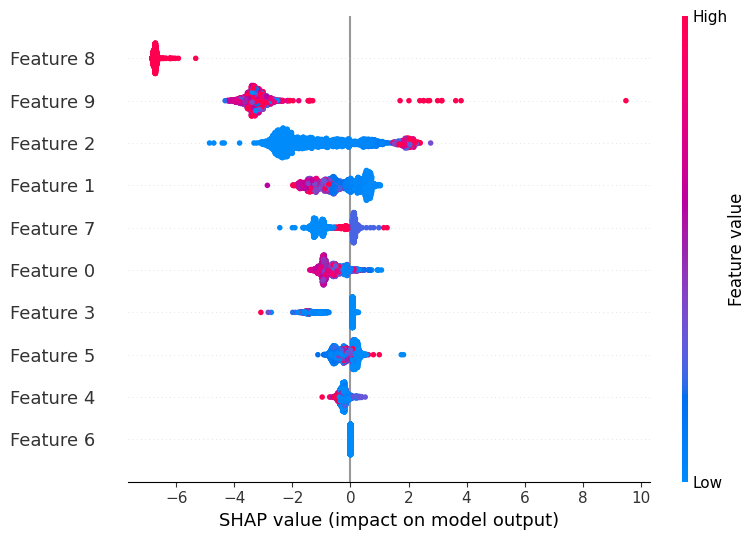

In [23]:

X_train_trans = pipeline.named_steps['preproc'].transform(X_train)

clf = pipeline.named_steps['clf']
explainer = shap.Explainer(clf)

sample_idx = np.random.choice(X_valid.shape[0], min(2000, X_valid.shape[0]), replace=False)
X_valid_sample = pipeline.named_steps['preproc'].transform(X_valid.iloc[sample_idx])
shap_values = explainer(X_valid_sample)
shap.summary_plot(shap_values, X_valid_sample, show=True)


In [24]:
joblib.dump(pipeline, "fraud_pipeline.joblib")
print("Saved pipeline to fraud_pipeline.joblib")


Saved pipeline to fraud_pipeline.joblib
